# YData Quality - Data Relations Tutorial
Time-to-Value: 12 minutes

This notebook provides a tutorial for the ydata_quality package functionality for data relations analysis.

**Structure:**

0. A data relations introduction
1. Load dataset
2. Instantiate the Data Relations engine
3. Run the quality checks
4. Assess the warnings
5. (Extra) Detailed overview

## A data relations introduction
### What are data relations?
Data relations are ways in which random variables associate themselves. Different variables collected in the same environment frequently share certain statistical properties. This is broadly called correlation, a measurement for how much two variables are related, and this property is important in all kinds of statistical models.
Prediction models leverage variables correlated with dependent features to produce good predictions; clustering models leverage correlations between covariates in order to group similar observations; and correlations are also studied as an important source of model explainability.
A usually undesired effect of correlation is multicollinearity, where predictor variables are correlated. Despite not being necessarily a negative aspect, since not always it leads to overfitting, it will often lead to a loss of model interpretability and overall reduction of significance of the covariates.

Causality is another type of data relation, similar to correlation although with a very important addition which is time dependence. A cause must always preclude the effect and not the other way around, where in correlation this is not a necessary condition. Causality is usually only possible to determine in datasets with explicit (timeseries) or implicit time dimensions (the candidate effect is measured after the candidate causes are observed).
***
### Why correlation is not so simple
Despite being a simple concept, a series of assumptions take place when  a correlation measurement method is put to work. The most commonly known metric of correlation is the [Pearson correlation coefficient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html), it is a number bounded in the [-1, 1] range and just the number itself indicates the strength of the correlation while the sign indicates positive or negative correlation (i.e. the quantities increase together or one increases while the other decreases). Nevertheless this metric is only indicated for comparing 2 continuous variables. In order to mitigate the impact of misplaced assumptions, there are a few aspects to take into consideration when making and interpreting these kinds of measurements:
- **Mixed datatypes -** When we want to measure the strength of association between different kinds of variables, say two discrete variables or even between a discrete and a continuous variable, we need to use appropriate metrics that output values in the same scale as Pearson's coefficient in order to be comparable. For pairs of categorical variables (i.e. discrete non-ordered), a typical metric is [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) which looks to measure the co-occurrence of categories of the different variables. Comparing continuous with discrete variables. For the discrete-continuous case a good example is the [Correlation Ratio](https://en.wikipedia.org/wiki/Correlation_ratio) that compares the dispersion of the continuous feature across the different labels of the discrete variable with the overall dispersion of the continuous variable.
- **Symmetry -** Some quantities used as correlation coefficients are not metrics since $C(X,Y)$ ≠ $C(Y,X)$. A good example is [Theil's U](https://en.wikipedia.org/wiki/Uncertainty_coefficient), where we measure the information content gained relative to one variable by knowing the other, the bigger this information gain the bigger the correlation. We can know if a month has 31 days or not by knowing if the month is February but the inverse is not true since it only provides us with partial information, we have bigger information gain and bigger Theil's U in the first scenario and this must be accounted for when using this quantity as proxy for correlation.
- **Geometry -** Pearson's coefficient measures association in linear space. This is an important distinction specially before considering feature transformation functions, like logarithmic or polynomial which might be able to strenghten the apparent correlation. A notable case is [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) which does not make any spatial assumption regarding the distribution of the variables, instead just considers rank coherence of the different elements of each array making it specially suited for ordinal variables (i.e. ordered discrete) while also working for continuous variables. A high Spearman but low Pearson correlation might indicate that a transformation to one of the variables might be able to linearize their association leading to high Pearson coefficient afterwards.
- **Independence -** High correlation does not imply causality, and although it might be tempting to consider strong associations as possible causes it is important to consider effects such as [confounding](https://catalogofbias.org/biases/confounding/) and [colliding](https://catalogofbias.org/biases/collider-bias/). The next section explains these effects in bigger detail and how we detect their potential existence.
***
### Confounding and colliding effects
As we saw in the previous section, confounding and colliding are effects that occur due to unaccounted dependence effects and can induce spurious correlations. Consider the famous examples of [ice-cream sales and drownings correlations](https://paularowinska.wordpress.com/2018/08/18/deadly-ice-cream/) or the [relationship between nesting storks and birth rate](https://datatab.net/tutorial/partial-correlation). Both examples might suggest causality between the respective pairs, but once we control for the effect of other variables (summer season and average area per inhabitant respectively) these apparently strong associations dilute. Note that we may not always be in possession of confounding variables in our dataset, meaning that even after controlling for all other variables, poisoned conclusions might be drawn due to a poor experimental design.

Not being mindful when controlling for the effect of other variables can lead to colliding biases. This phenomena occurs typically when we control for the collider variable, a variable influenced by the pair of variables for which we are measuring association. A recent article published in Nature Communications identified [colliding biases with some COVID-19 observational studies](https://www.nature.com/articles/s41467-020-19478-2) from which we take an example: Health workers are naturally exposed to higher viral loads, let's hypothesize that being a health worker has a causal relationship with high severity COVID-19 disease. The only reliable estimator for severe infections are positive PCR, which during the beginning of the pandemic were scarce. PCR were available to health workers or hospitalized members of the general public. The study sample therefore included health workers, independent of the severity of symptoms, and hospitalized non-health workers (control population) usually with severe symptoms making health workers seem less susceptible to high severity COVID-19, making our hypothesis less likely.

We cannot assume the domain expertise to perfectly identify confounding and colliding bias. But we can make your job easier, for confounding effects we look strong binary associations, after controlling for the effect of other variables in the dataset, if the association strongly diluted we will raise your attention to potential confounding effects. If the inverse situation applies (weak association before control, high association afterwards) we will flag potential colliding effects.
***
### How do we study correlations?
We developed this module in order to help you study the correlation structures of your data and retrieving actionable insights.

We raise your awareness to potential biases in data relations in your dataset so that they are less likely to negatively impact your analysis. We also help you identifying the most and the least important features. We do this by leveraging techniques such as correlation methods above, full order partial correlations (i.e. controlling the effect of all covariates) and with [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor), which is used to assess multicollinearity of numerical covariates.

# Data correlations demo and tutorial
## Imports

In [1]:
from ydata_quality.data_relations import DataRelationsDetector
import pandas as pd

## Load the example dataset
We will use the wine dataset available from the sklearn package.

In [2]:
df = pd.read_csv('../datasets/transformed/census_10k.csv')
df.drop(columns=['education-num'], inplace=True)  # This column is a numerical alias for the educational column

## Create the engine

In [3]:
drd = DataRelationsDetector()

### Full Evaluation
The easiest way to assess the data quality analysis is to run `.evaluate()` which returns a list of warnings for each quality check.
To run evaluate with the Data Relations Detector you provide:
- df (pd.DataFrame): The Pandas DataFrame on which you want to perform data relations analysis.
- dtypes (Optional[dict]): A dictionary mapping df column names to numerical/categorical dtypes.
    If a full map is not provided it will be determined/completed via inference method.
- label (Optional[str]): A string identifying the label feature column
- corr_th (float): Absolute threshold for high correlation detection. Defaults to 0.8.
- vif_th (float): Variance Inflation Factor threshold, typically 5-10 is recommended. Defaults to 5.

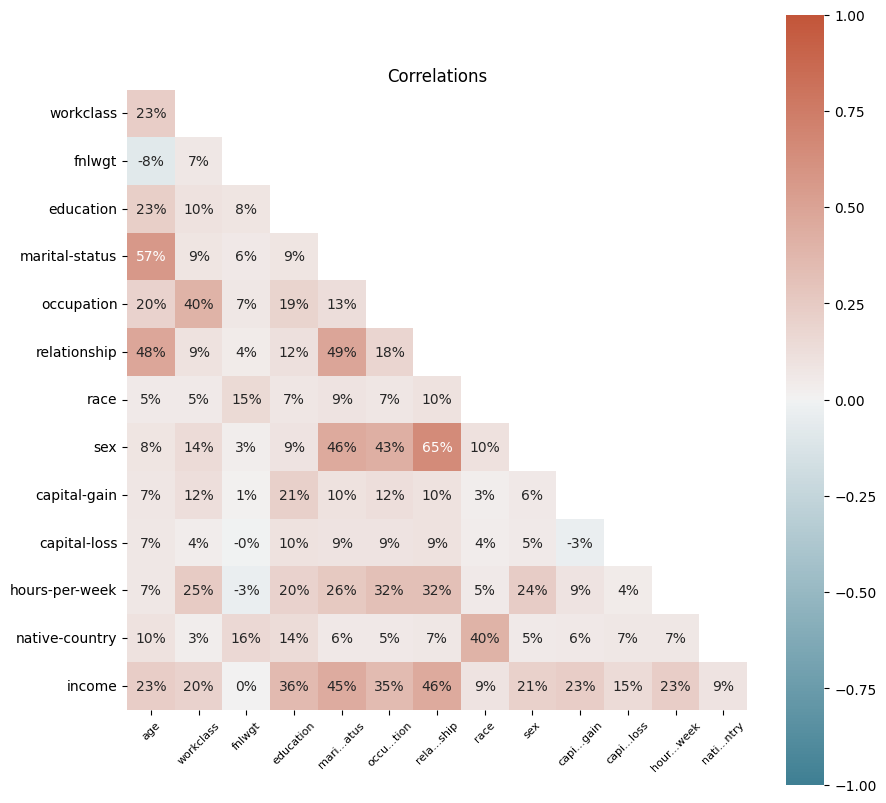

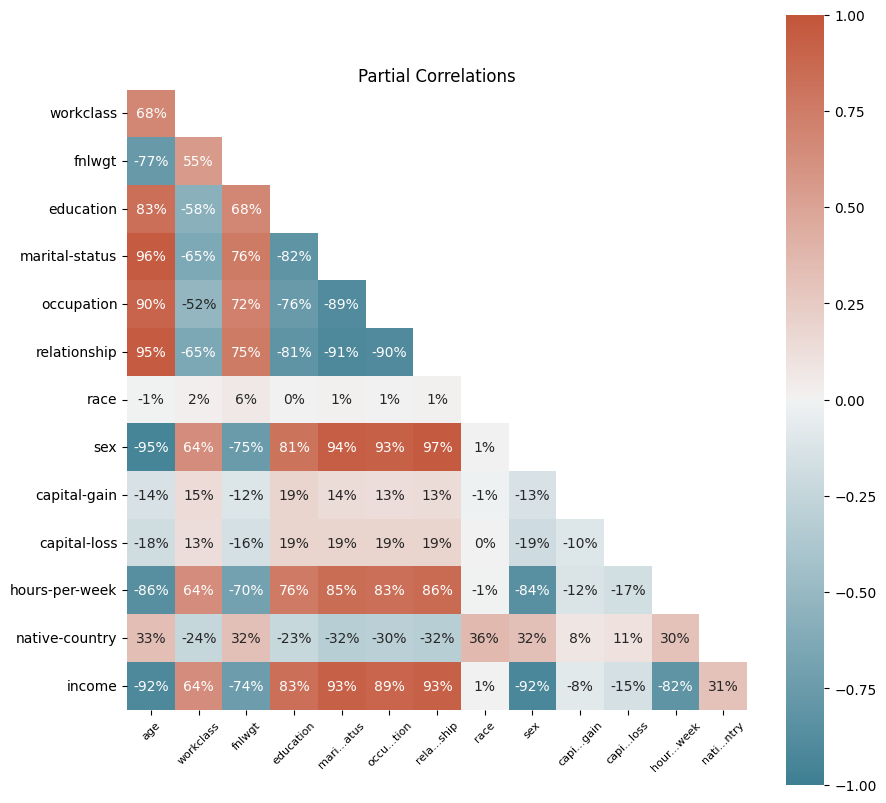

In [4]:
results = drd.evaluate(df, None, 'income')

## Check the status
After running the data quality checks, you can check the warnings for each individual test. The warnings are suited by priority and have additional details that can provide better insights for Data Scientists.

In [5]:
drd.report()

Warnings count by priority:
	Priority 2: 2 warning(s)
	TOTAL: 2 warning(s)
List of warnings sorted by priority:
	[COLLIDER CORRELATIONS] Found 26 independently uncorrelated variable pairs that showed correlation after controling for the remaining variables. This is an indicator of potential colliding bias with other covariates. (Priority 2: usage allowed, limited human intelligibility)
	[HIGH COLLINEARITY - CATEGORICAL] Found 9 categorical variables with significant collinearity (p-value < 0.05). The variables listed in results are highly collinear with other variables in the dataset and sorted descending according to propensity. These will make model explainability harder and potentially give way to issues like overfitting. Depending on your end goal you might want to remove variables following the provided order. (Priority 2: usage allowed, limited human intelligibility)


## Check the results
The evaluate method produced a series of results. These are structured according to different tests that were executed.

### Confounders
On confounders we can get feedback on bivariate correlation pairs that are potentially being confounded by other covariates, this means that the apparent correlation is in fact dependent on other covariates.

In [6]:
results['Confounders']

[]

### Colliders
On colliders we can get feedback on pairs that might get wrongly interpreted as being highly correlated after controlling the effect of covariates that can be caused independently by each variable of the bivariate pair.

Per example if we accept age and relationship status as potential causes for marital status then we need to be careful when assessing the correlation between age and relationship status after controlling for marital status.

In [7]:
results['Colliders']

[('age', 'education'),
 ('age', 'marital-status'),
 ('age', 'occupation'),
 ('age', 'relationship'),
 ('age', 'sex'),
 ('age', 'hours-per-week'),
 ('age', 'income'),
 ('education', 'marital-status'),
 ('education', 'relationship'),
 ('education', 'sex'),
 ('education', 'income'),
 ('marital-status', 'occupation'),
 ('marital-status', 'relationship'),
 ('marital-status', 'sex'),
 ('marital-status', 'hours-per-week'),
 ('marital-status', 'income'),
 ('occupation', 'relationship'),
 ('occupation', 'sex'),
 ('occupation', 'hours-per-week'),
 ('occupation', 'income'),
 ('relationship', 'sex'),
 ('relationship', 'hours-per-week'),
 ('relationship', 'income'),
 ('sex', 'hours-per-week'),
 ('sex', 'income'),
 ('hours-per-week', 'income')]

### Feature Importance
On feature importance we can find a priority list of important features relative to the label, these are filtered based on the zero order correlation values and corr_th. Potential confounding is flagged when a candidate important feature loses relevance after controlling for the other covariates.

In [8]:
results['Feature Importance']

'[FEATURE IMPORTANCE] No important features were found in explaining income. You might want to try lowering corr_th.'

### Inflated Variance
On inflated variance we rank numerical features by the Variance Inflation Factor of their respective coefficients (in a linear model). This is an indicator of multicollinearity. Typically values higher than 5 signify multicollinearity and should be investigated, bigger than 10 signify serious multicollinearity.

Categorical variables are sorted according to a collinearity score through chi squared tests in all bivariate combinations. The most collinear with the remaining variables are ranked first.

Depending on your goal, you might want to keep the features or drop them all together. An iterative process is recommended if the option is to drop, starting by the highest VIFs or the first ranked categorical variables in the collinearity score.

In [9]:
results['High Collinearity']['Categorical']

['native-country',
 'marital-status',
 'relationship',
 'workclass',
 'race',
 'sex',
 'workclass2',
 'occupation',
 'education']